In [1]:
import sys 
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import torch.nn.functional as F
import scipy
import pandas as pd
import os
import glob
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('science')
pd.set_option('display.float_format', lambda x: '%.4e' % x)
# import seaborn as sns
from utils import create_expdf, fetch_subdf
from dataset.generate_dataset_1d import poisson_kernel, logarithm_kernel
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.utils import rl2_error
from matplotlib import ticker

In [2]:
exp_df = create_expdf('../results')

Result of GN and GN-aug on 1D logarithm problem

In [3]:
# process green's function
idx = 257
nh = 513
h = 2/(nh-1) # x in [-1, 1]
xh = torch.linspace(-1,1,nh)
x_i = torch.cartesian_prod(xh, xh)
G = logarithm_kernel(x_i[:,0], x_i[:,1], h).numpy()#.reshape(nh, nh)
G_gn_rl2s = []
G_gnaug_rl2s = []

for i in [0,1,2,3,4]:
    gn_log_kernel = np.load('../results/logarithm/GN1D-rational-513-50-1.0000-none-{:}/approx_kernel.npy'.format(i))
    gnaug_log_kernel = np.load('../results/logarithm/GN1D-rational-513-50-1.0000-aug2-{:}/approx_kernel.npy'.format(i))
    G_gn = gn_log_kernel.reshape(-1)/(h) #.reshape(513,513) / h
    G_gnaug = gnaug_log_kernel/(h) #.reshape(513,513) / h
    G_gn_rl2s.append(rl2_error(G_gn, G))
    G_gnaug_rl2s.append(rl2_error(G_gnaug, G))


log1d_exps = exp_df[(exp_df.task_nm=='logarithm') & (exp_df.p==1)]

gn_mean = log1d_exps[log1d_exps.aug == 'none'].rl2.mean()
gn_std = log1d_exps[log1d_exps.aug == 'none'].rl2.std()

gnaug_mean = log1d_exps[log1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = log1d_exps[log1d_exps.aug == 'aug2'].rl2.std()

print('logarithm 1D')
print("G rl2 GL : {:.3f} +/- {:.3f}".format(np.mean(G_gn_rl2s)*100, np.std(G_gn_rl2s)*100))
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))

print("G rl2 GL-aug : {:.3f} +/- {:.3f}".format(np.mean(G_gnaug_rl2s)*100, np.std(G_gnaug_rl2s)*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))

print("G improve {:}".format(1 - np.mean(G_gnaug_rl2s)/np.mean(G_gn_rl2s)))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))


logarithm 1D
G rl2 GL : 10.628 +/- 0.285
u rl2 GL : 0.075 +/- 0.005
G rl2 GL-aug : 8.492 +/- 0.538
u rl2 GL-aug : 0.055 +/- 0.006
G improve 0.20100545265029646
u improve 0.266883311262178


Result of GN and GN-aug on 1D poisson problem

In [4]:
# process green's function
idx = 257
nh = 513
h = 1/(nh-1) # x in [-1, 1]
xh = torch.linspace(0,1,nh)
x_i = torch.cartesian_prod(xh, xh)
G = poisson_kernel(x_i[:,0], x_i[:,1], h).numpy()#.reshape(nh, nh)
G_gn_rl2s = []
G_gnaug_rl2s = []

for i in [0,1,2,3,4]:
    gn_poisson_kernel = np.load('../results/poisson1d/GN1D-rational-513-50-1.0000-none-{:}/approx_kernel.npy'.format(i))
    gnaug_poisson_kernel = np.load('../results/poisson1d/GN1D-rational-513-50-1.0000-aug2-{:}/approx_kernel.npy'.format(i))
    G_gn = gn_poisson_kernel.reshape(-1)/h #.reshape(513,513) / h
    G_gnaug = gnaug_poisson_kernel/h #.reshape(513,513) / h
    G_gn_rl2s.append(rl2_error(G_gn, G))
    G_gnaug_rl2s.append(rl2_error(G_gnaug, G))


poisson1d_exps = exp_df[(exp_df.task_nm=='poisson1d') & (exp_df.p==1)]

gn_mean = poisson1d_exps[poisson1d_exps.aug == 'none'].rl2.mean()
gn_std = poisson1d_exps[poisson1d_exps.aug == 'none'].rl2.std()

gnaug_mean = poisson1d_exps[poisson1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = poisson1d_exps[poisson1d_exps.aug == 'aug2'].rl2.std()

print("poisson 1D")
print("G rl2 GL : {:.3f} +/- {:.3f}".format(np.mean(G_gn_rl2s)*100, np.std(G_gn_rl2s)*100))
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))

print("G rl2 GL-aug : {:.3f} +/- {:.3f}".format(np.mean(G_gnaug_rl2s)*100, np.std(G_gnaug_rl2s)*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))

print("G improve {:}".format(1 - np.mean(G_gnaug_rl2s)/np.mean(G_gn_rl2s)))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))


poisson 1D
G rl2 GL : 0.271 +/- 0.008
u rl2 GL : 0.064 +/- 0.006
G rl2 GL-aug : 0.078 +/- 0.012
u rl2 GL-aug : 0.047 +/- 0.003
G improve 0.7124315859047607
u improve 0.2644741005553356


Result of GN and GN-aug on 1D Schrodinger problem

In [5]:
G_gn_rl2s = []
G_gnaug_rl2s = []

schrodinger1d_exps = exp_df[(exp_df.task_nm=='schrodinger1d') & (exp_df.p==1)]

gn_mean = schrodinger1d_exps[schrodinger1d_exps.aug == 'none'].rl2.mean()
gn_std = schrodinger1d_exps[schrodinger1d_exps.aug == 'none'].rl2.std()

gnaug_mean = schrodinger1d_exps[schrodinger1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = schrodinger1d_exps[schrodinger1d_exps.aug == 'aug2'].rl2.std()

print('Schrodinger')
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

Schrodinger
u rl2 GL : 0.189 +/- 0.020
u rl2 GL-aug : 0.140 +/- 0.034
u improve 0.25863743267933714


Result of GN and GN-aug on 1D Airy problem

In [6]:
G_gn_rl2s = []
G_gnaug_rl2s = []

airy1d_exps = exp_df[(exp_df.task_nm=='airy1d') & (exp_df.p==1)]

gn_mean = airy1d_exps[airy1d_exps.aug == 'none'].rl2.mean()
gn_std = airy1d_exps[airy1d_exps.aug == 'none'].rl2.std()

gnaug_mean = airy1d_exps[airy1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = airy1d_exps[airy1d_exps.aug == 'aug2'].rl2.std()

print('airy')
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

airy
u rl2 GL : 0.077 +/- 0.012
u rl2 GL-aug : 0.071 +/- 0.008
u improve 0.07938580821463759


Result of GN and GN-aug on 1D Boundary problem

In [7]:
G_gn_rl2s = []
G_gnaug_rl2s = []

boundary1d_exps = exp_df[(exp_df.task_nm=='boundary1d') & (exp_df.p==1)]

gn_mean = boundary1d_exps[boundary1d_exps.aug == 'none'].rl2.mean()
gn_std = boundary1d_exps[boundary1d_exps.aug == 'none'].rl2.std()

gnaug_mean = boundary1d_exps[boundary1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = boundary1d_exps[boundary1d_exps.aug == 'aug2'].rl2.std()

print("boundary")
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

boundary
u rl2 GL : 0.048 +/- 0.009
u rl2 GL-aug : 0.042 +/- 0.004
u improve 0.12359598068106092


Result of GN and GN-aug on 2D Poisson

In [8]:
G_gn_rl2s = []
G_gnaug_rl2s = []

poisson2d_exps = exp_df[(exp_df.task_nm=='poissonrect') & (exp_df.p==0.2)]

gn_mean = poisson2d_exps[poisson2d_exps.aug == 'none'].rl2.mean()
gn_std = poisson2d_exps[poisson2d_exps.aug == 'none'].rl2.std()

gnaug_mean = poisson2d_exps[poisson2d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = poisson2d_exps[poisson2d_exps.aug == 'aug2'].rl2.std()

print("poisson2d")
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

poisson2d
u rl2 GL : 0.867 +/- 0.170
u rl2 GL-aug : 0.828 +/- 0.096
u improve 0.044642916675535216


Result of GN and GN-aug on 2D Darcy

In [9]:
G_gn_rl2s = []
G_gnaug_rl2s = []

darcy2d_exps = exp_df[(exp_df.task_nm=='darcyrect') & (exp_df.p==0.2)]

gn_mean = darcy2d_exps[darcy2d_exps.aug == 'none'].rl2.mean()
gn_std = darcy2d_exps[darcy2d_exps.aug == 'none'].rl2.std()

gnaug_mean = darcy2d_exps[darcy2d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = darcy2d_exps[darcy2d_exps.aug == 'aug2'].rl2.std()

print("poisson2d")
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

poisson2d
u rl2 GL : 1.202 +/- 0.107
u rl2 GL-aug : 1.185 +/- 0.089
u improve 0.013581526319945025


GreenMG poisson 1D

In [50]:
def gmgplot(ax, exp_df, task, title, ylim):
    gl_exps = exp_df[((exp_df.task_nm==task) & (exp_df.k==0)) & (exp_df.aug=='none')]
    gl_mean_table = pd.pivot_table(gl_exps, values=['rl2'], index=['k'], columns=['p'])

    gmg_exps = exp_df[(exp_df.task_nm==task) & (exp_df.k!=0)]
    gmg_mean_table = pd.pivot_table(gmg_exps, values=['rl2'], index=['k'], columns=['m'])
    gmg_p_table = pd.pivot_table(gmg_exps, values=['p'], index=['k'], columns=['m'])

    glaug_exps = exp_df[((exp_df.task_nm==task) & (exp_df.k==0)) & (exp_df.aug=='aug2')]
    glaug_mean_table = pd.pivot_table(glaug_exps, values=['rl2'], index=['k'], columns=['p'])
    ps = np.array([x[1] for x in gl_mean_table.columns.tolist()])

    ax.plot(ps, gl_mean_table.values[0], '.-r', label='GL')
    ax.plot(ps, glaug_mean_table.values[0], '.-g', label='GL-aug')
    ax.plot(gmg_p_table.values[0], gmg_mean_table.values[0], '-*b', label='$k=1$')
    ax.plot(gmg_p_table.values[1], gmg_mean_table.values[1], '-xb', label='$k=2$')
    ax.plot(gmg_p_table.values[2], gmg_mean_table.values[2], '-+b', label='$k=3$')
    ax.set_xlabel('$p$')
    ax.set_ylabel('$\mathcal{\\epsilon}_u$', rotation=0)


    # for m, (x, y) in enumerate(zip(gmg_p_table.values[0], gmg_mean_table.values[0])):
        # plt.text(x,y, '$(k=1,m={:})$'.format(m))
    ax.set_ylim(ylim)
    ax.title.set_text(title)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
    ax.set_yscale("log")
    ax.set_xscale("log")

    # f.legend(bbox_to_anchor=(0.95,0.9),loc='upper left', borderaxespad=0.)

    # outnm = '../vis/{:}_gmg.png'.format(task)
    # plt.savefig(outnm)

    return ax

In [51]:
float_formatter = lambda x: "%.3f" % x
vec_float_formatter = np.vectorize(float_formatter)

In [52]:
gl_exps = exp_df[((exp_df.task_nm=='poisson1d') & (exp_df.k==0)) & (exp_df.aug=='none')]
gl_mean_table = pd.pivot_table(gl_exps, values=['rl2'], index=['k'], columns=['p'])
gl_std_table = pd.pivot_table(gl_exps, values=['rl2'], index=['k'], columns=['p'], aggfunc='std')

glaug_exps = exp_df[((exp_df.task_nm=='poisson1d') & (exp_df.k==0)) & (exp_df.aug=='aug2')]
glaug_mean_table = pd.pivot_table(glaug_exps, values=['rl2'], index=['k'], columns=['p'])
glaug_std_table = pd.pivot_table(glaug_exps, values=['rl2'], index=['k'], columns=['p'], aggfunc='std')
ps = np.array([x[1] for x in gl_mean_table.columns.tolist()])

gmg_exps = exp_df[(exp_df.task_nm=='poisson1d') & (exp_df.k!=0)]
gmg_mean_table = pd.pivot_table(gmg_exps, values=['rl2'], index=['k'], columns=['m'])
gmg_std_table = pd.pivot_table(gmg_exps, values=['rl2'], index=['k'], columns=['m'], aggfunc='std')
gmg_p_table = pd.pivot_table(gmg_exps, values=['p'], index=['k'], columns=['m'])

mean_strarray = vec_float_formatter(gmg_mean_table.values*100)
std_strarray = vec_float_formatter(gmg_std_table.values*100)

In [53]:
dollar = np.full((3,6), '$')
pm = np.full((3,6), '\pm')
tmp = np.char.add(dollar, mean_strarray)
tmp = np.char.add(tmp, pm) 
tmp = np.char.add(tmp, std_strarray) 
tmp = np.char.add(tmp, dollar) 

poisson1d_result_table = pd.DataFrame(
    tmp, columns=['$m=0$','$m=1$','$m=3$','$m=7$','$m=15$','$m=31$'],
    index=['1','2','3'])

print(poisson1d_result_table.to_latex(index=True))

\begin{tabular}{lllllll}
\toprule
 & $m=0$ & $m=1$ & $m=3$ & $m=7$ & $m=15$ & $m=31$ \\
\midrule
1 & $0.048\pm0.004$ & $0.047\pm0.003$ & $0.046\pm0.003$ & $0.047\pm0.003$ & $0.048\pm0.003$ & $0.048\pm0.002$ \\
2 & $0.055\pm0.003$ & $0.047\pm0.003$ & $0.049\pm0.003$ & $0.048\pm0.004$ & $0.049\pm0.002$ & $0.048\pm0.002$ \\
3 & $0.091\pm0.003$ & $0.049\pm0.003$ & $0.049\pm0.003$ & $0.050\pm0.004$ & $0.048\pm0.002$ & $0.049\pm0.004$ \\
\bottomrule
\end{tabular}



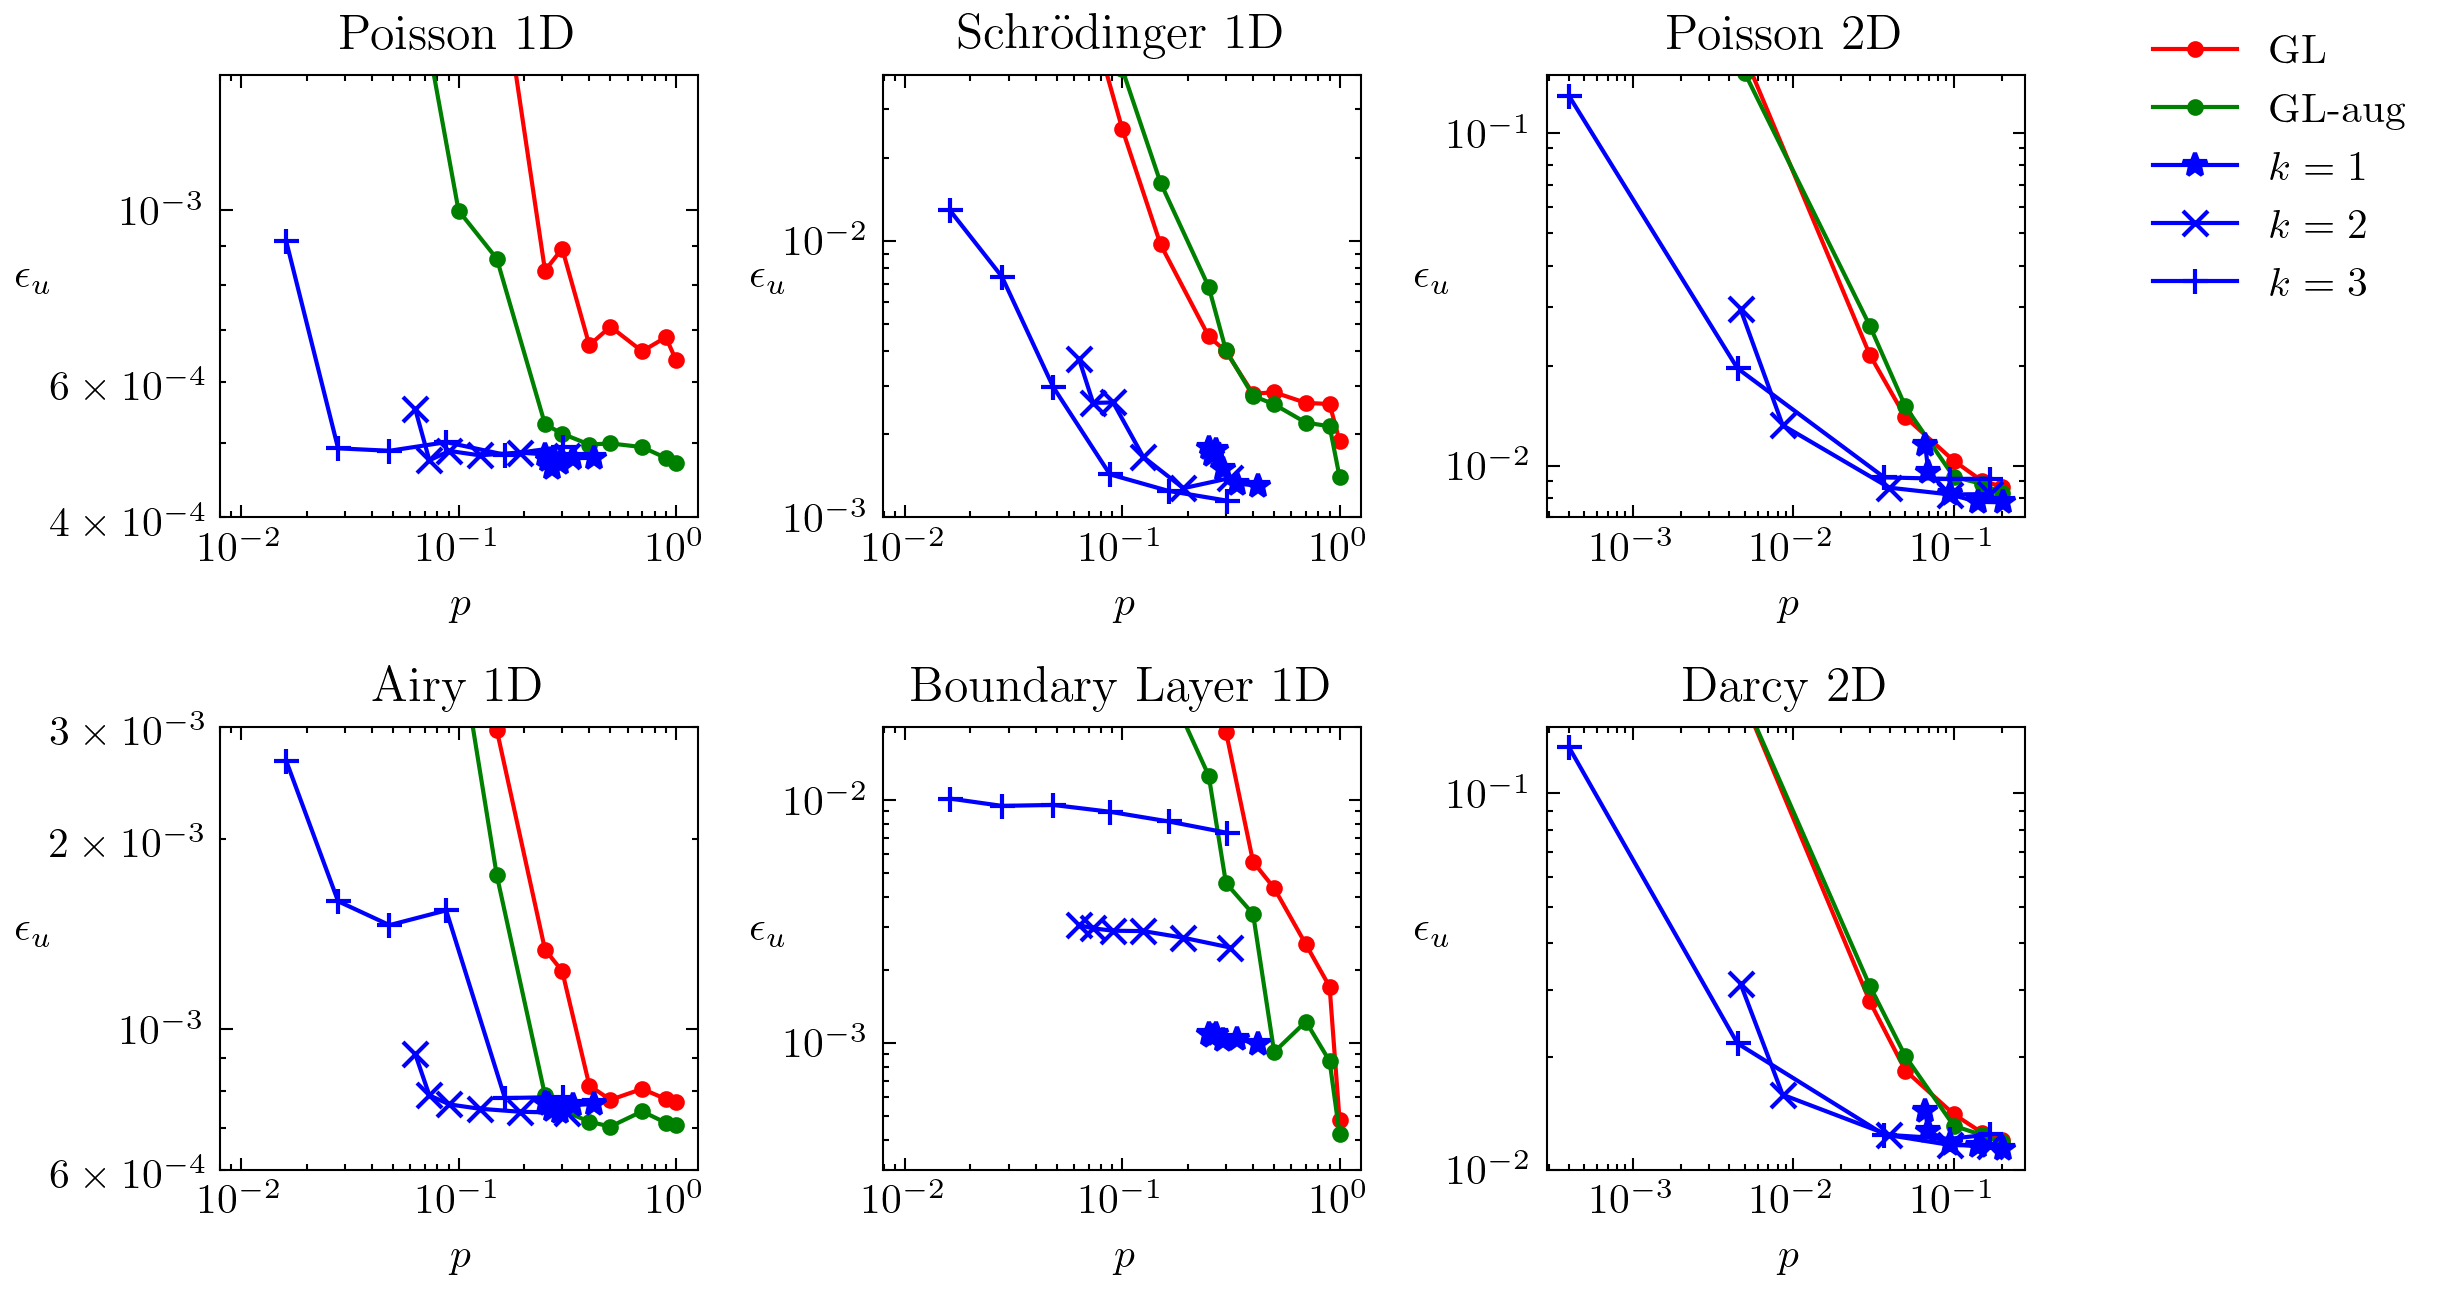

In [56]:
plt.rcParams["mathtext.fontset"] = "stix"
f = plt.figure(figsize=(7, 4.5))
ax_poisson = plt.subplot(2,3,1)
gmgplot(ax_poisson, exp_df, 'poisson1d', 'Poisson 1D', [4e-4, 1.5e-3])
ax_schrodinger = plt.subplot(2,3,2)
gmgplot(ax_schrodinger, exp_df, 'schrodinger1d', '$\\text{Schr\\"{o}dinger}$ 1D', [1e-3, 4e-2])
ax_airy = plt.subplot(2,3,4)
gmgplot(ax_airy, exp_df, 'airy1d', 'Airy 1D', [6e-4, 3e-3])
ax_boundarylayer = plt.subplot(2,3,5)
gmgplot(ax_boundarylayer, exp_df, 'boundary1d', 'Boundary Layer 1D', [3e-4, 2e-2])
ax_poissonrect = plt.subplot(2,3,3)
gmgplot(ax_poissonrect, exp_df, 'poissonrect', 'Poisson 2D', [7e-3, 1.5e-1])
ax_darcyrect = plt.subplot(2,3,6)
gmgplot(ax_darcyrect, exp_df, 'darcyrect', 'Darcy 2D', [1e-2, 1.5e-1])

labels_handles = {
  label: handle for ax in f.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

f.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc = "upper center",
  bbox_to_anchor = (1.1, .98),
  bbox_transform = plt.gcf().transFigure,
)

# f.legend(loc='outside upper right')
plt.tight_layout()

outnm = '../vis/section5/gmgn_result.pdf'
plt.savefig(outnm)

In [17]:
gl_mean_table.columns

MultiIndex([('rl2', 0.01),
            ('rl2', 0.03),
            ('rl2', 0.05),
            ('rl2', 0.07),
            ('rl2',  0.1),
            ('rl2', 0.15),
            ('rl2', 0.25),
            ('rl2',  0.3),
            ('rl2',  0.4),
            ('rl2',  0.5),
            ('rl2',  0.7),
            ('rl2',  0.9),
            ('rl2',  1.0)],
           names=[None, 'p'])

GreenMG Schrodinger 1D

In [187]:
exps = exp_df[(exp_df.task_nm=='schrodinger1d') & (exp_df.k!=0)]
mean_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m']) * 100
mean_strarray = vec_float_formatter(mean_table.values)

std_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m'], aggfunc='std') * 100
std_strarray = vec_float_formatter(std_table.values)

dollar = np.full((3,6), '$')
pm = np.full((3,6), '\pm')
tmp = np.char.add(dollar, mean_strarray)
tmp = np.char.add(tmp, pm) 
tmp = np.char.add(tmp, std_strarray) 
tmp = np.char.add(tmp, dollar) 

schrodinger1d_result_table = pd.DataFrame(
    tmp, columns=['$m=0$','$m=1$','$m=3$','$m=7$','$m=15$','$m=31$'],
    index=['1','2','3'])

print(schrodinger1d_result_table.to_latex(index=True))

\begin{tabular}{lllllll}
\toprule
 & $m=0$ & $m=1$ & $m=3$ & $m=7$ & $m=15$ & $m=31$ \\
\midrule
1 & $0.178\pm0.020$ & $0.168\pm0.024$ & $0.175\pm0.027$ & $0.150\pm0.033$ & $0.133\pm0.037$ & $0.130\pm0.041$ \\
2 & $0.374\pm0.009$ & $0.260\pm0.017$ & $0.261\pm0.016$ & $0.166\pm0.036$ & $0.128\pm0.024$ & $0.139\pm0.036$ \\
3 & $1.291\pm0.002$ & $0.744\pm0.005$ & $0.296\pm0.006$ & $0.143\pm0.018$ & $0.125\pm0.023$ & $0.115\pm0.017$ \\
\bottomrule
\end{tabular}



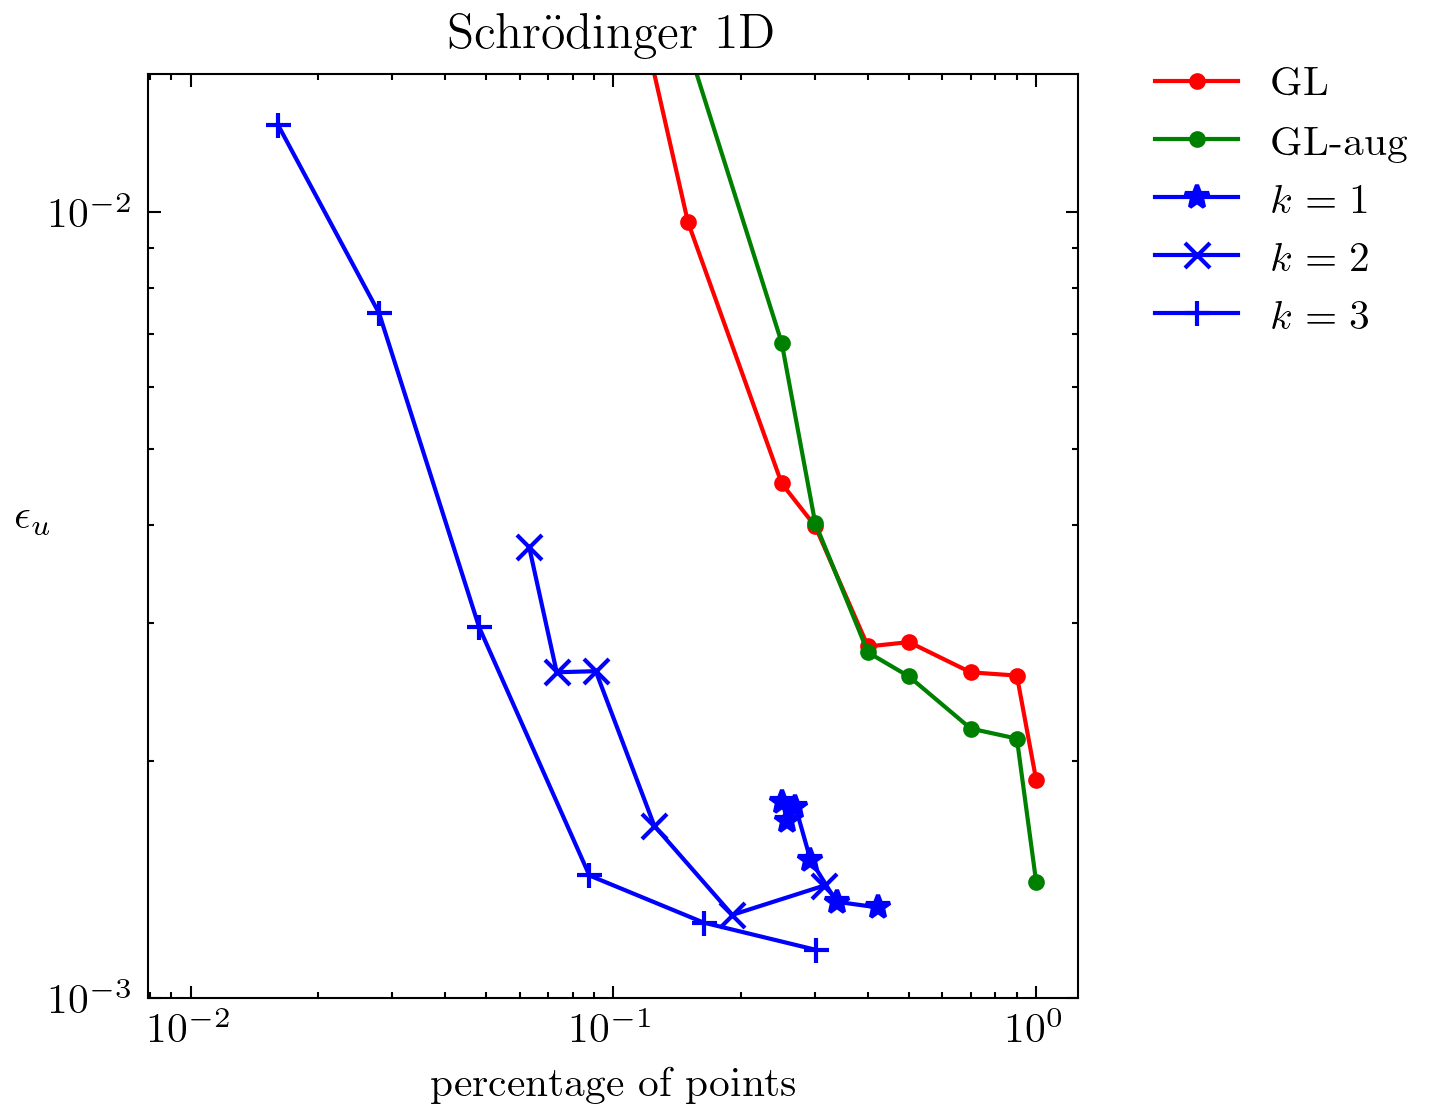

In [197]:
f = gmgplot(exp_df, 'schrodinger1d', '$\\text{Schr\\"{o}dinger}$ 1D', [1e-3, 1.5e-2])

GreenMG Airy1D

In [14]:
exps = exp_df[(exp_df.task_nm=='airy1d') & (exp_df.k!=0)]
mean_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m']) * 100
mean_strarray = vec_float_formatter(mean_table.values)

std_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m'], aggfunc='std') * 100
std_strarray = vec_float_formatter(std_table.values)

dollar = np.full((3,6), '$')
pm = np.full((3,6), '\pm')
tmp = np.char.add(dollar, mean_strarray)
tmp = np.char.add(tmp, pm) 
tmp = np.char.add(tmp, std_strarray) 
tmp = np.char.add(tmp, dollar) 

airy1d_result_table = pd.DataFrame(
    tmp, columns=['$m=0$','$m=1$','$m=3$','$m=7$','$m=15$','$m=31$'],
    index=['1','2','3'])

print(airy1d_result_table.to_latex(index=True))

\begin{tabular}{lllllll}
\toprule
 & $m=0$ & $m=1$ & $m=3$ & $m=7$ & $m=15$ & $m=31$ \\
\midrule
1 & $0.077\pm0.009$ & $0.076\pm0.011$ & $0.075\pm0.009$ & $0.074\pm0.010$ & $0.076\pm0.011$ & $0.076\pm0.009$ \\
2 & $0.091\pm0.009$ & $0.079\pm0.010$ & $0.076\pm0.012$ & $0.075\pm0.010$ & $0.074\pm0.008$ & $0.074\pm0.009$ \\
3 & $0.265\pm0.213$ & $0.159\pm0.219$ & $0.146\pm0.190$ & $0.154\pm0.227$ & $0.078\pm0.011$ & $0.078\pm0.009$ \\
\bottomrule
\end{tabular}



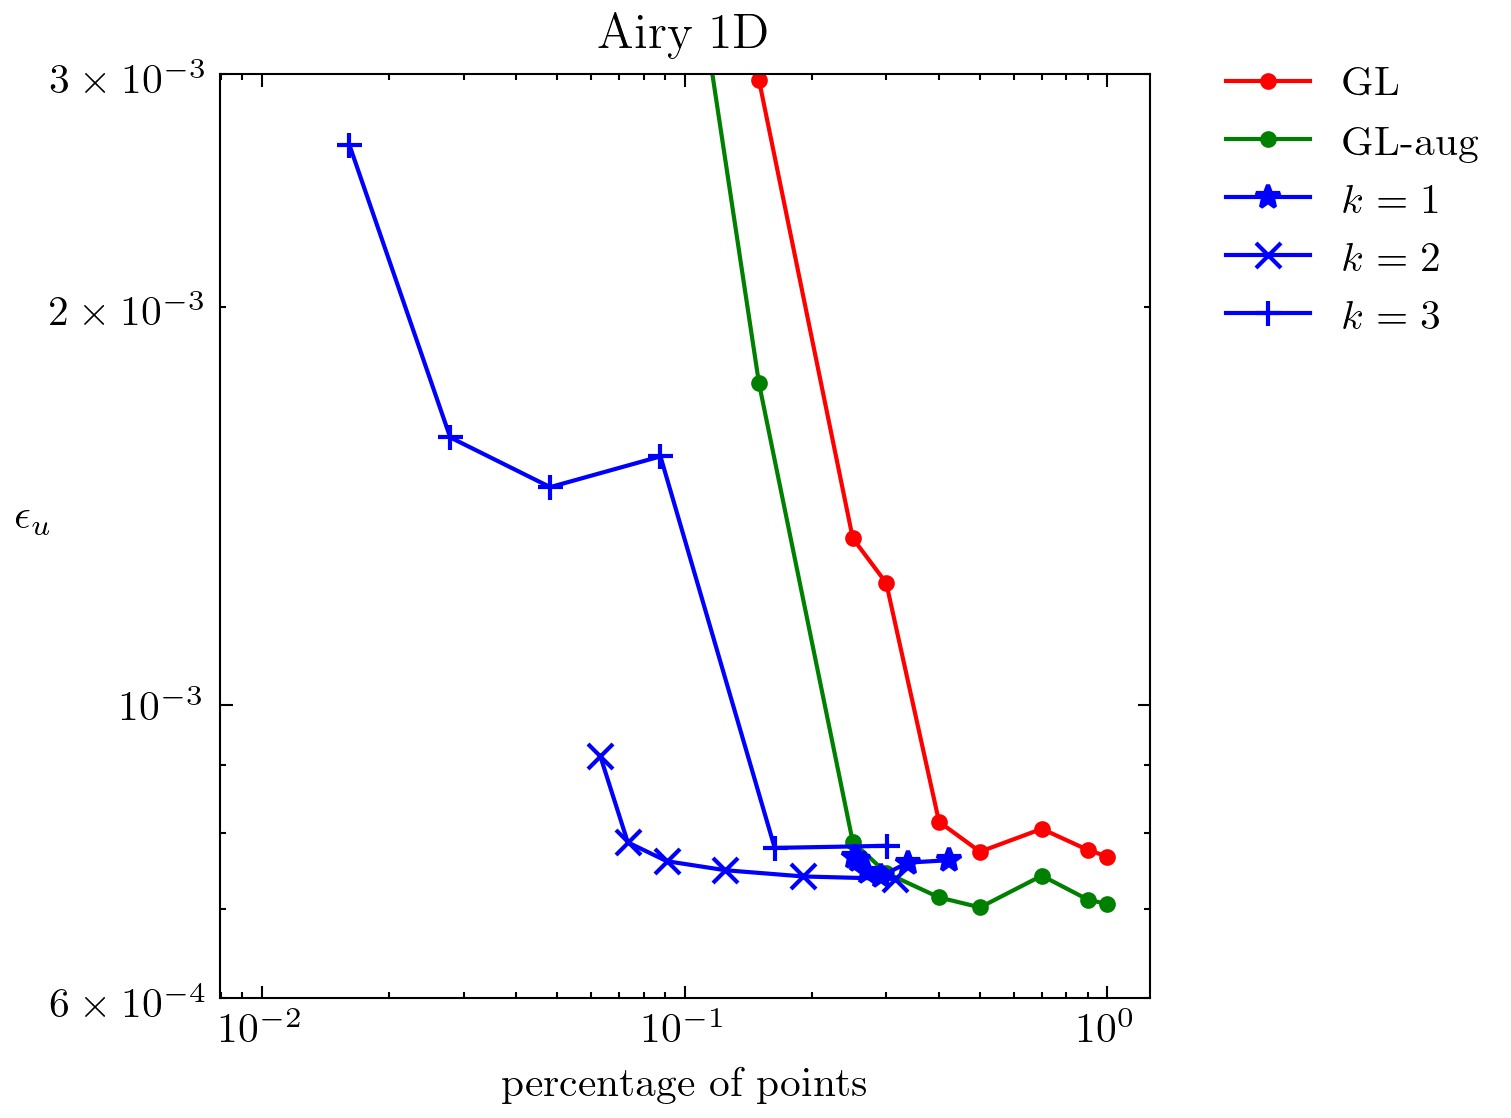

In [196]:
f = gmgplot(exp_df, 'airy1d', 'Airy 1D', [6e-4, 3e-3])

GreenMG boundary 1D

In [16]:
exps = exp_df[(exp_df.task_nm=='boundary1d') & (exp_df.k!=0)]
mean_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m']) * 100
mean_strarray = vec_float_formatter(mean_table.values)

std_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m'], aggfunc='std') * 100
std_strarray = vec_float_formatter(std_table.values)

dollar = np.full((3,6), '$')
pm = np.full((3,6), '\pm')
tmp = np.char.add(dollar, mean_strarray)
tmp = np.char.add(tmp, pm) 
tmp = np.char.add(tmp, std_strarray) 
tmp = np.char.add(tmp, dollar) 

boundary1d_result_table = pd.DataFrame(
    tmp, columns=['$m=0$','$m=1$','$m=3$','$m=7$','$m=15$','$m=31$'],
    index=['1','2','3'])

print(boundary1d_result_table.to_latex(index=True))

\begin{tabular}{lllllll}
\toprule
 & $m=0$ & $m=1$ & $m=3$ & $m=7$ & $m=15$ & $m=31$ \\
\midrule
1 & $0.109\pm0.003$ & $0.107\pm0.003$ & $0.109\pm0.003$ & $0.102\pm0.003$ & $0.104\pm0.002$ & $0.099\pm0.002$ \\
2 & $0.306\pm0.001$ & $0.297\pm0.006$ & $0.290\pm0.001$ & $0.289\pm0.001$ & $0.271\pm0.001$ & $0.247\pm0.002$ \\
3 & $1.016\pm0.001$ & $0.947\pm0.004$ & $0.956\pm0.004$ & $0.896\pm0.002$ & $0.817\pm0.005$ & $0.735\pm0.005$ \\
\bottomrule
\end{tabular}



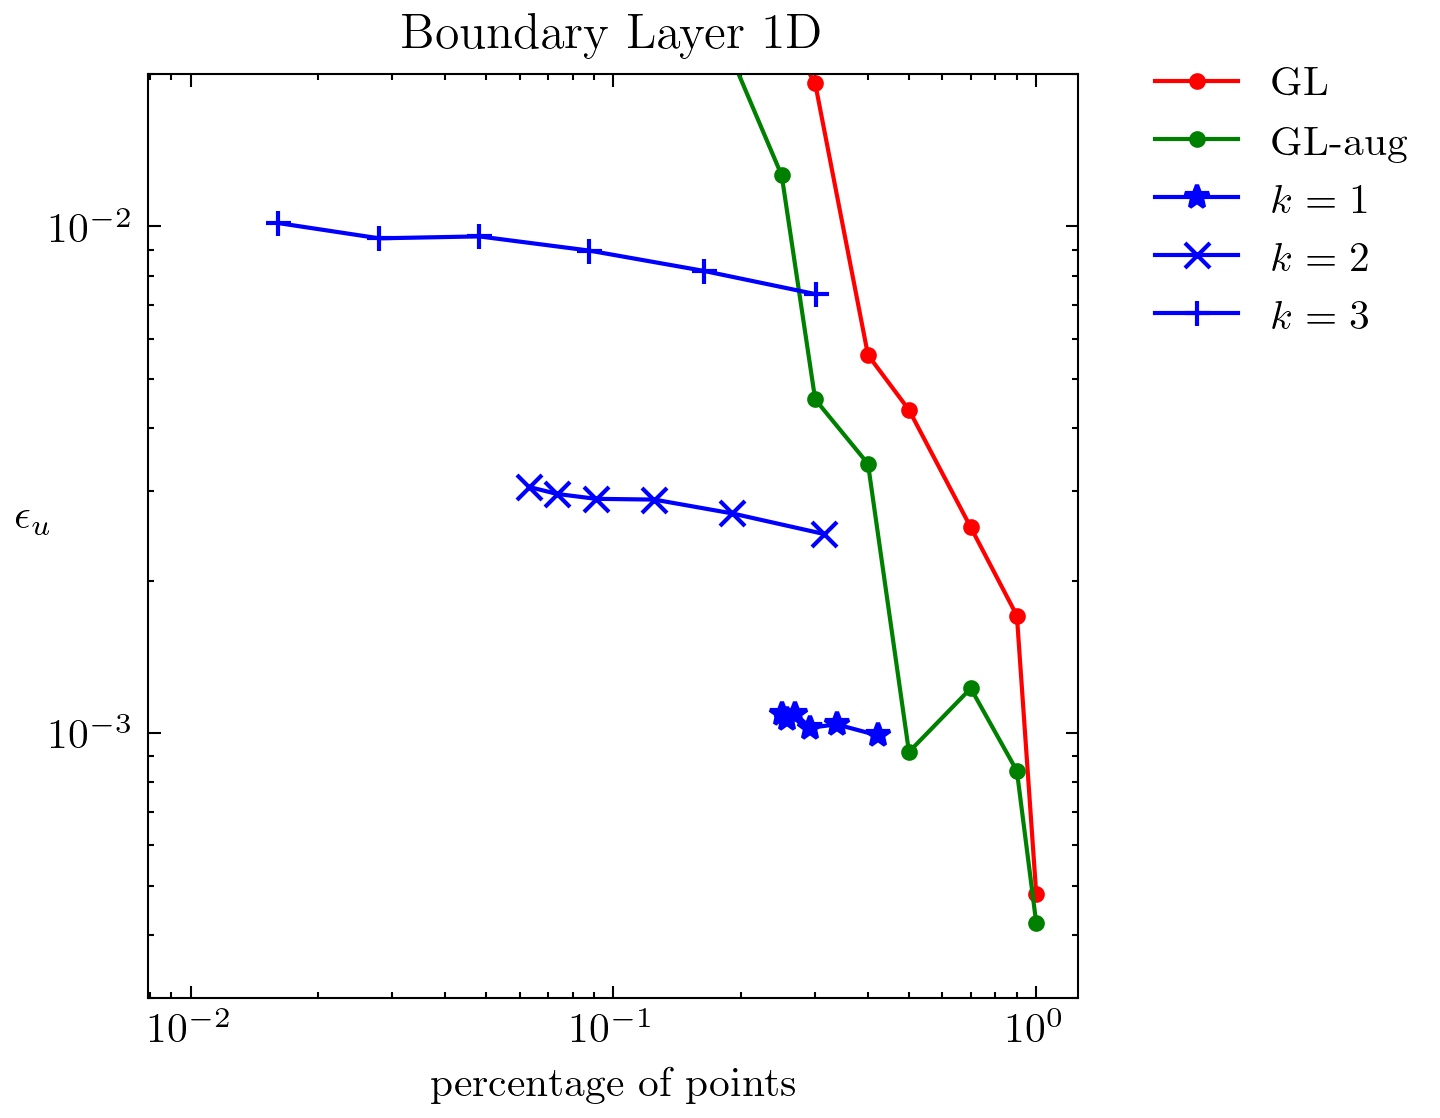

In [203]:
f = gmgplot(exp_df, 'boundary1d', 'Boundary Layer 1D', [3e-4, 2e-2])

GreenMG Poissonrect

In [19]:
exps = exp_df[(exp_df.task_nm=='poissonrect') & (exp_df.k!=0)]
mean_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m']) * 100
mean_strarray = vec_float_formatter(mean_table.values)

std_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m'], aggfunc='std') * 100
std_strarray = vec_float_formatter(std_table.values)

dollar = np.full((3,5), '$')
pm = np.full((3,5), '\pm')
tmp = np.char.add(dollar, mean_strarray)
tmp = np.char.add(tmp, pm) 
tmp = np.char.add(tmp, std_strarray) 
tmp = np.char.add(tmp, dollar) 

poissonrect_result_table = pd.DataFrame(
    tmp, columns=['$m=0$','$m=1$','$m=3$', '$m=5$', '$m=7$'],
    index=['1','2','3'])

print(poissonrect_result_table.to_latex(index=True))

\begin{tabular}{llllll}
\toprule
 & $m=0$ & $m=1$ & $m=3$ & $m=5$ & $m=7$ \\
\midrule
1 & $1.157\pm0.095$ & $0.958\pm0.088$ & $0.821\pm0.115$ & $0.780\pm0.120$ & $0.777\pm0.111$ \\
2 & $2.956\pm0.063$ & $1.326\pm0.091$ & $0.860\pm0.120$ & $0.820\pm0.178$ & $0.823\pm0.162$ \\
3 & $12.976\pm0.011$ & $1.964\pm0.041$ & $0.924\pm0.073$ & $0.914\pm0.099$ & $0.915\pm0.091$ \\
\bottomrule
\end{tabular}



In [30]:
gmg_exps = exp_df[(exp_df.task_nm=='poissonrect') & (exp_df.k!=0)]
gmg_mean_table = pd.pivot_table(gmg_exps, values=['rl2'], index=['k'], columns=['m'])
gmg_p_table = pd.pivot_table(gmg_exps, values=['p'], index=['k'], columns=['m'])

In [31]:
gmg_p_table

p                                            
m          0          1          3          5          7
k                                                       
1 6.6400e-02 6.9600e-02 9.4800e-02 1.4100e-01 2.0360e-01
2 4.7000e-03 8.6000e-03 3.9700e-02 9.5500e-02 1.6940e-01
3 4.0000e-04 4.5000e-03 3.6900e-02 9.4200e-02 1.6910e-01

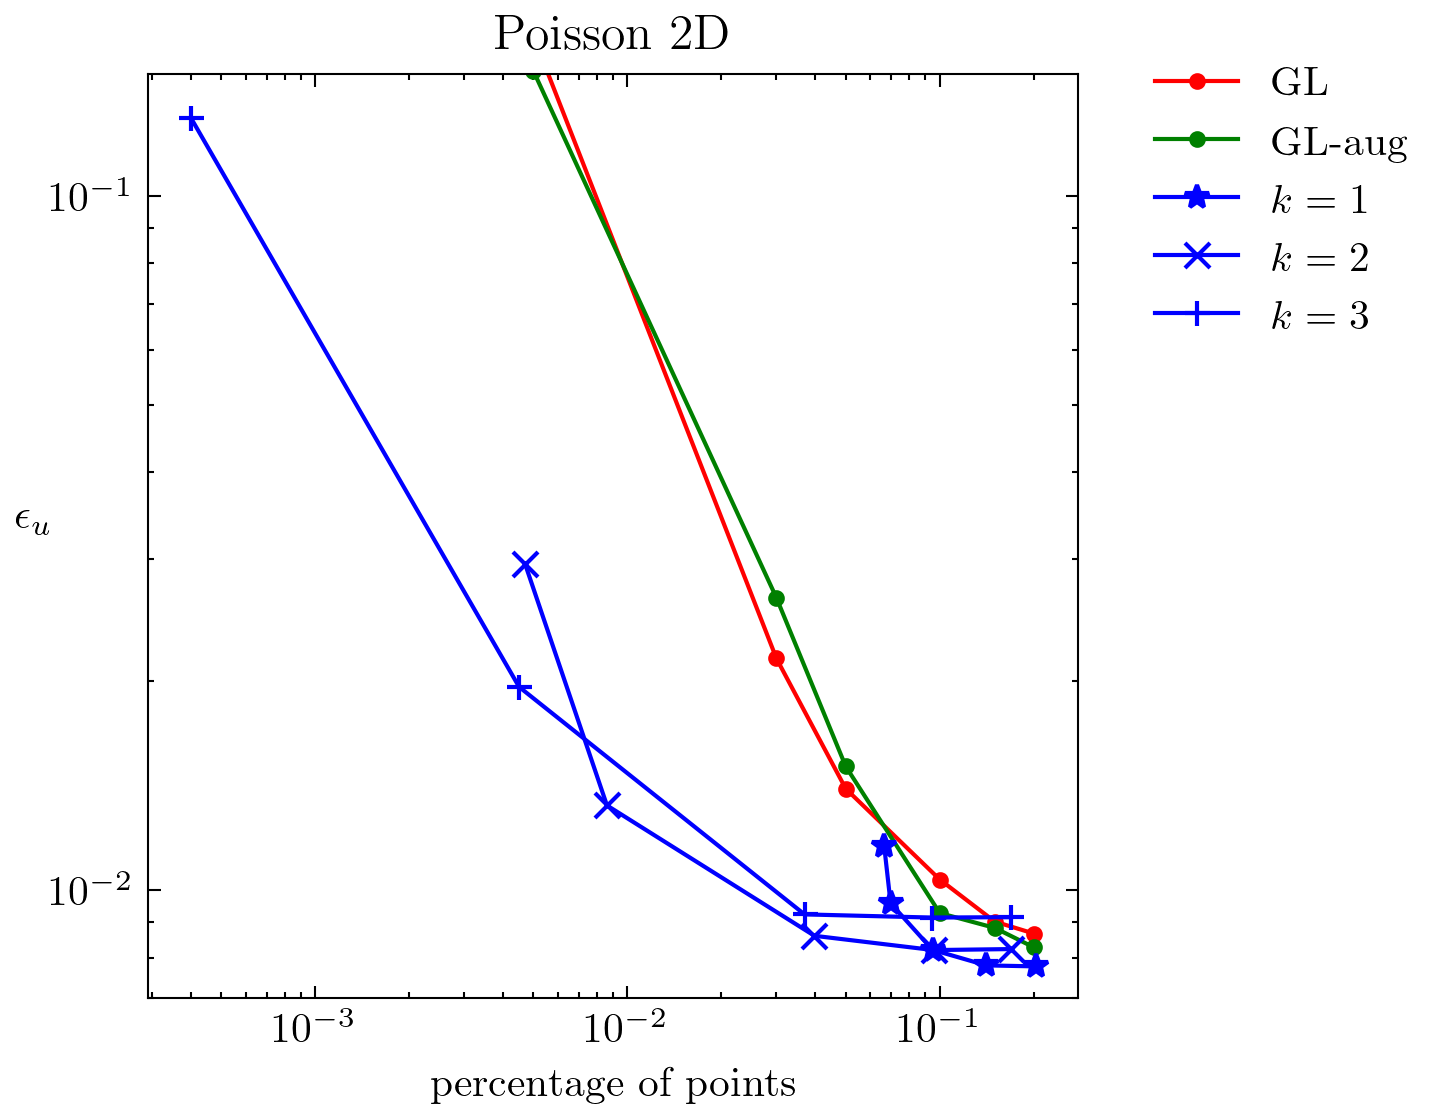

In [213]:
f = gmgplot(exp_df, 'poissonrect', 'Poisson 2D', [7e-3, 1.5e-1])

GreenMG Darcyrect

In [57]:
exps = exp_df[(exp_df.task_nm=='darcyrect') & (exp_df.k!=0)]
mean_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m']) * 100
mean_strarray = vec_float_formatter(mean_table.values)

std_table = pd.pivot_table(exps, values=['rl2'], index=['k'], columns=['m'], aggfunc='std') * 100
std_strarray = vec_float_formatter(std_table.values)

dollar = np.full((3,5), '$')
pm = np.full((3,5), '\pm')
tmp = np.char.add(dollar, mean_strarray)
tmp = np.char.add(tmp, pm) 
tmp = np.char.add(tmp, std_strarray) 
tmp = np.char.add(tmp, dollar) 

darcyrect_result_table = pd.DataFrame(
    tmp, columns=['$m=0$','$m=1$','$m=3$', '$m=5$', '$m=7$'],
    index=['1','2','3'])

print(darcyrect_result_table.to_latex(index=True))

\begin{tabular}{llllll}
\toprule
 & $m=0$ & $m=1$ & $m=3$ & $m=5$ & $m=7$ \\
\midrule
1 & $1.433\pm0.079$ & $1.272\pm0.089$ & $1.175\pm0.098$ & $1.156\pm0.120$ & $1.137\pm0.117$ \\
2 & $3.123\pm0.038$ & $1.584\pm0.086$ & $1.237\pm0.146$ & $1.165\pm0.123$ & $1.159\pm0.115$ \\
3 & $13.292\pm0.010$ & $2.168\pm0.025$ & $1.241\pm0.057$ & $1.210\pm0.057$ & $1.243\pm0.069$ \\
\bottomrule
\end{tabular}



In [62]:
gl_exps = exp_df[((exp_df.task_nm=='darcyrect') & (exp_df.k==0)) & (exp_df.aug=='none')]

In [63]:
gl_exps.p.unique()

array([0.001, 0.005, 0.03 , 0.05 , 0.1  , 0.15 , 0.2  ])

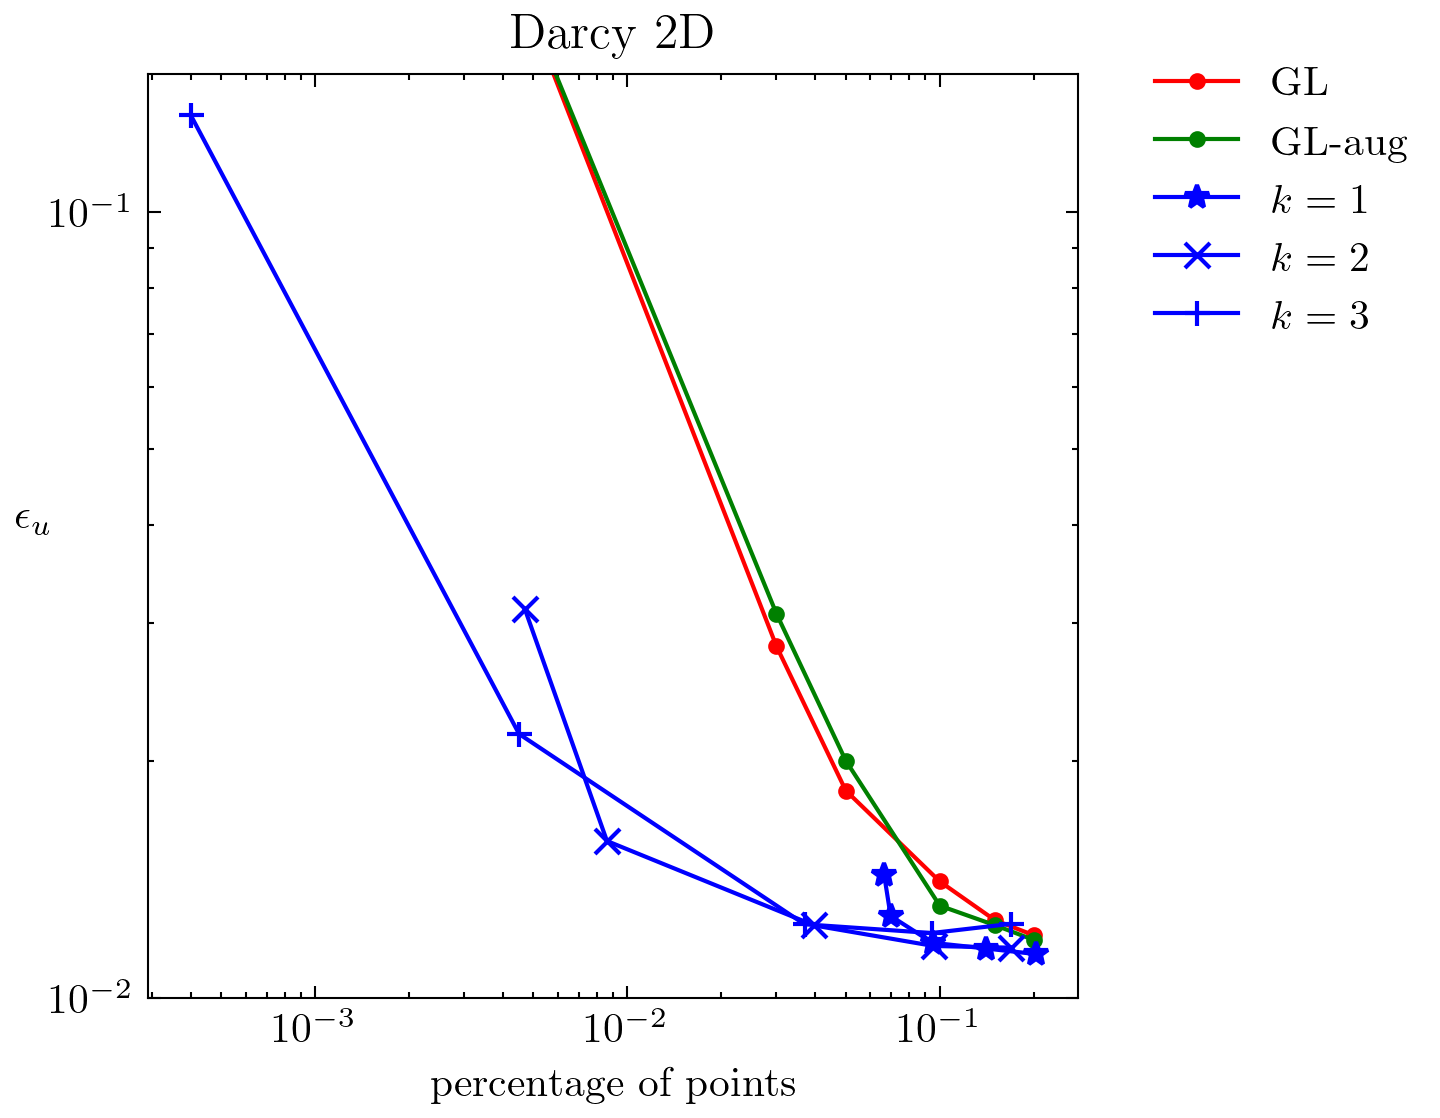

In [216]:
f = gmgplot(exp_df, 'darcyrect', 'Darcy 2D', [1e-2, 1.5e-1])